In [1]:
from da_od.config import test_img
from da_od.model import DepthAnythingEstimator, MiDaSEstimator, MonocularDepthEstimator

image_path = test_img / "DALLE.jpeg"

In [2]:
DepthAnything_estimator = DepthAnythingEstimator(image_path, encoder="vits")
DepthAnything_colored, DepthAnything_raw = DepthAnything_estimator.process_image()

INFO:dinov2:using MLP layer as FFN


In [3]:
# MiDaS_estimator = MiDaSEstimator(image_path, model_type="DPT_Large")
# MiDaS_colored, MiDaS_raw = MiDaS_estimator.process_image()

In [4]:
# Monocular_estimator = MonocularDepthEstimator(image_path, model_name="mono_640x192")
# Monocular_colored, Monocular_raw = Monocular_estimator.process_image()

In [5]:
# import random

# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

# from da_od.config import class_names, output_img, sam_weights
# from da_od.model import seg_sam, yolo_nas
# from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

# # image_path = output_img / "DALLE.jpeg"
# class_names_file = class_names / "coco.names.txt"
# output_folder_path = output_img / "segmentation.jpg"
# checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


# def read_class_names(file_path):
#     with open(file_path) as file:
#         class_names = [line.strip() for line in file.readlines()]
#     return class_names


# classNames = read_class_names(class_names_file)

# bboxes, confidence, labels, class_names, image = yolo_nas.get_object_detection(DepthAnything_colored)

# # Instantiate mask generator
# mask_generator = SamAutomaticMaskGenerator(seg_sam.get_model(checkpoint_path))
# mask = mask_generator.generate(image)
# seg_sam.show_anns(mask)

# # Create a predictor for SAM
# # image = cv2.imread(str(output_img / "DA_DALLE_depth_colormap.jpg"))
# predictor = SamPredictor(seg_sam.get_model(checkpoint_path))
# predictor.set_image(image)

# # Initialize a combined mask
# combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

# # Loop through detections
# for i, label in enumerate(labels):
#     input_box = np.array(bboxes[i])

#     # Predict mask using SAM
#     mask, _, _ = predictor.predict(
#         point_coords=None, point_labels=None, box=input_box[None, :], multimask_output=False
#     )

#     # Get the correct class label
#     cls = int(label)
#     class_name = classNames[cls]

#     # Draw bounding box
#     x_min, y_min, x_max, y_max = input_box
#     cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

#     # Add label
#     cv2.putText(
#         image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
#     )

#     # Generate random color for mask
#     random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
#     mask_color = np.array(random_color)

#     # Add the mask to the combined mask with the random color
#     combined_mask += mask[0][..., None] * mask_color

# # Overlay the original image with the combined mask
# final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)


# # Display the image
# plt.close("all")
# plt.figure(figsize=(10, 10))
# plt.imshow(final_image)
# plt.axis("off")
# plt.savefig(output_folder_path)  # Save the combined output
# plt.show()

In [6]:
from __future__ import annotations

from pathlib import Path
from typing import Protocol

import cv2
import numpy as np
from super_gradients.training import models


class PredictionDetail(Protocol):
    """A protocol representing the detailed prediction results from an object detection model.

    Attributes:
        labels (list[str]): A list of label strings for detected objects.
        confidence (list[float]): A list of confidence scores corresponding to each detected object.
        bboxes_xyxy (list[tuple[float, float, float, float]]): A list of bounding boxes for detected objects,
            each represented as a tuple (x1, y1, x2, y2), where (x1, y1) is the top left corner and
            (x2, y2) is the bottom right corner of the bounding box.
    """

    labels: list[str]
    confidence: list[float]
    bboxes_xyxy: list[tuple[float, float, float, float]]


class PredictionResult(Protocol):
    """A protocol for the aggregated result of an object detection prediction.

    This class encapsulates both the class names identified in the detection process
    and the detailed prediction results including labels, confidence scores, and bounding boxes.

    Attributes:
        class_names (list[str]): A list of all class names detected by the model.
        prediction (PredictionDetail): An instance of PredictionDetail containing detailed
            prediction results for each detected object.
    """

    class_names: list[str]
    prediction: PredictionDetail


class ObjectDetector:
    """A class for detecting objects in images using specified models.

    Attributes:
        model (Any): The object detection model.
        conf_threshold (float): The confidence threshold for the detections.

    Args:
        model_name (str): The name of the model to use. Defaults to "yolo_nas_l".
        pretrained_weights (str): The pretrained weights to use with the model. Defaults to "coco".
        conf_threshold (float): The confidence threshold for considering detections. Defaults to 0.25.
    """

    def __init__(
        self: ObjectDetector,
        model_name: str = "yolo_nas_l",
        pretrained_weights: str = "coco",
        conf_threshold: float = 0.25,
    ) -> None:
        """Initializes the ObjectDetector with a specific model,its pretrained weights & confidence threshold.

        This method sets up the object detection model with the specified configurations. It loads the model
        using the provided model name and pretrained weights. The confidence threshold for detections
        is also set, which determines the minimum confidence for detected objects to be considered valid.

        Args:
        model_name (str): The name of the detection model to use. Defaults to "yolo_nas_l", which
            indicates a specific type of YOLO model. The available models are dependent on the
            implementation of the `models.get` method.
        pretrained_weights (str): The name of the dataset on which the model was pretrained. Defaults
            to "coco", indicating the COCO dataset. This parameter is passed directly to the model
            loading mechanism and affects model initialization.
        conf_threshold (float): The minimum confidence score that a detection must have to be
            considered valid. This threshold helps to filter out less confident detections to
            improve the precision of the object detection. Defaults to 0.25.

        The initialization process involves calling an external model loading function, which is expected
        to return an instance of the detection model. This model is then used for object detection tasks.
        """
        self.model = models.get(model_name, pretrained_weights=pretrained_weights)
        self.conf_threshold = conf_threshold

    def get_prediction_info(
        self: ObjectDetector,
        predictions: PredictionResult,
    ) -> tuple[list[tuple[float, float, float, float]], list[float], list[str], list[str]]:
        """Extracts and returns relevant information from prediction results.

        Args:
            predictions: The prediction results from the object detection model.

        Returns:
            A tuple containing the bounding boxes, confidence scores, labels, and class names from the predictions.
        """
        class_names = predictions.class_names
        labels = predictions.prediction.labels
        confidence = predictions.prediction.confidence
        bboxes = predictions.prediction.bboxes_xyxy
        return bboxes, confidence, labels, class_names

    def detect_objects(
        self: ObjectDetector,
        image_input: Path | np.ndarray,
    ) -> tuple[list[tuple[float, float, float, float]], list[float], list[str], list[str], np.ndarray]:
        """Detects objects in the given image.

        Args:
            image_input (Path | np.ndarray): The input image, either as a file path or as an image array (np.ndarray).

        Raises:
            ValueError: If the image input is neither a file path nor an image array.

        Returns:
            tuple[list[Tuple[float, float, float, float]], list[float], list[str], list[str], np.ndarray]:
            The bounding boxes, confidence scores, labels, class names of detected objects, and the processed image array.
        """
        if isinstance(image_input, Path):
            image = cv2.imread(str(image_input))
            if image is None:
                path_message = "Failed to load image from the provided file path."
                raise ValueError(path_message)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif isinstance(image_input, np.ndarray):
            image = cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB)
        else:
            formating_path_message = (
                "Image input must be a file path (Path) or an image array (numpy.ndarray)"
            )
            raise TypeError(formating_path_message)

        detection_pred = self.model.predict(image, conf=self.conf_threshold)
        bboxes, confidence, labels, class_names = self.get_prediction_info(detection_pred)
        return bboxes, confidence, labels, class_names, image


# import random

# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

# from da_od.config import class_names, output_img, sam_weights
# from da_od.model import seg_sam
# from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

# # image_path = output_img / "DALLE.jpeg"
# class_names_file = class_names / "coco.names.txt"
# output_folder_path = output_img / "segmentation.jpg"
# checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


# def read_class_names(file_path):
#     with open(file_path) as file:
#         class_names = [line.strip() for line in file.readlines()]
#     return class_names


# classNames = read_class_names(class_names_file)

# object_detector = ObjectDetector(model_name="yolo_nas_l", pretrained_weights="coco", conf_threshold=0.25)
# bboxes, confidence, labels, class_names, image = object_detector.detect_objects(DepthAnything_colored)


# # Instantiate mask generator
# mask_generator = SamAutomaticMaskGenerator(seg_sam.get_model(checkpoint_path))
# mask = mask_generator.generate(image)
# seg_sam.show_anns(mask)

# # Create a predictor for SAM
# # image = cv2.imread(str(output_img / "DA_DALLE_depth_colormap.jpg"))
# predictor = SamPredictor(seg_sam.get_model(checkpoint_path))
# predictor.set_image(image)

# # Initialize a combined mask
# combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

# # Loop through detections
# for i, label in enumerate(labels):
#     input_box = np.array(bboxes[i])

#     # Predict mask using SAM
#     mask, _, _ = predictor.predict(
#         point_coords=None, point_labels=None, box=input_box[None, :], multimask_output=False
#     )

#     # Get the correct class label
#     cls = int(label)
#     class_name = classNames[cls]

#     # Draw bounding box
#     x_min, y_min, x_max, y_max = input_box
#     cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

#     # Add label
#     cv2.putText(
#         image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
#     )

#     # Generate random color for mask
#     random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
#     mask_color = np.array(random_color)

#     # Add the mask to the combined mask with the random color
#     combined_mask += mask[0][..., None] * mask_color

# # Overlay the original image with the combined mask
# final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)


# # Display the image
# plt.close("all")
# plt.figure(figsize=(10, 10))
# plt.imshow(final_image)
# plt.axis("off")
# plt.savefig(output_folder_path)  # Save the combined output
# plt.show()

[2024-03-07 15:15:34] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /Users/maryam/sg_logs/console.log


[2024-03-07 15:15:34] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-03-07 15:15:34,238] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
[2024-03-07 15:15:36] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-07 15:15:36] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-07 15:15:36] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-03-07 15:15:36] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from da_od.segment_anything import sam_model_registry


class SamModelManager:
    def __init__(self, checkpoint_path, model_type="vit_h"):
        self.checkpoint_path = checkpoint_path
        self.model_type = model_type
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = self.load_model()

    def load_model(self):
        sam = sam_model_registry[self.model_type](checkpoint=self.checkpoint_path)
        sam.to(device=self.device)
        return sam


class VisualizationTools:
    @staticmethod
    def show_mask(mask, ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    @staticmethod
    def show_points(coords, labels, ax, marker_size=365):
        pos_points = coords[labels == 1]
        neg_points = coords[labels == 0]
        ax.scatter(
            pos_points[:, 0],
            pos_points[:, 1],
            color="green",
            marker="*",
            s=marker_size,
            edgecolor="white",
            linewidth=1.25,
        )
        ax.scatter(
            neg_points[:, 0],
            neg_points[:, 1],
            color="red",
            marker="*",
            s=marker_size,
            edgecolor="white",
            linewidth=1.25,
        )

    @staticmethod
    def show_box(box, ax):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))

    @staticmethod
    def show_anns(anns):
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)

        img = np.ones((sorted_anns[0]["segmentation"].shape[0], sorted_anns[0]["segmentation"].shape[1], 4))
        img[:, :, 3] = 0
        for ann in sorted_anns:
            m = ann["segmentation"]
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask

In [8]:
# import random
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

# from da_od.config import class_names, output_img, sam_weights
# from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

# class_names_file = class_names / "coco.names.txt"
# output_folder_path = output_img / "segmentation.jpg"
# checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


# def read_class_names(file_path):
#     with open(file_path) as file:
#         class_names = [line.strip() for line in file.readlines()]
#     return class_names


# classNames = read_class_names(class_names_file)

# # Assuming you have an ObjectDetector class correctly set up
# object_detector = ObjectDetector(model_name="yolo_nas_l", pretrained_weights="coco", conf_threshold=0.25)
# bboxes, confidence, labels, class_names, image = object_detector.detect_objects(DepthAnything_colored)

# # Instantiate SamModelManager for SAM model handling
# sam_model_manager = SamModelManager(checkpoint_path)

# # Using SamModelManager's model attribute
# mask_generator = SamAutomaticMaskGenerator(sam_model_manager.model)
# mask = mask_generator.generate(image)

# # Create a predictor for SAM using SamModelManager's model
# predictor = SamPredictor(sam_model_manager.model)
# predictor.set_image(image)

# # Initialize a combined mask
# combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

# # Visualization tool for showing annotations
# visualization_tools = VisualizationTools()

# # Loop through detections
# for i, label in enumerate(labels):
#     input_box = np.array(bboxes[i])

#     # Predict mask using SAM
#     mask, _, _ = predictor.predict(
#         point_coords=None, point_labels=None, box=input_box[None, :], multimask_output=False
#     )

#     # Get the correct class label
#     cls = int(label)
#     class_name = classNames[cls]

#     # Draw bounding box
#     x_min, y_min, x_max, y_max = input_box
#     cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

#     # Add label
#     cv2.putText(
#         image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
#     )

#     # Generate random color for mask
#     random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
#     mask_color = np.array(random_color)

#     # Add the mask to the combined mask with the random color
#     combined_mask += mask[0][..., None] * mask_color

# # Overlay the original image with the combined mask
# final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)

# # Display the final image using matplotlib
# plt.close("all")
# plt.figure(figsize=(10, 10))
# plt.imshow(final_image)
# plt.axis("off")
# plt.savefig(output_folder_path)  # Save the combined output
# plt.show()

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# from da_od.segment_anything import sam_model_registry


# class ModelManager:
#     def __init__(self, checkpoint_path):
#         self.checkpoint_path = checkpoint_path
#         self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#         self.model = None

#     def load_model(self, model_type="vit_h"):
#         if self.model is None:
#             self.model = sam_model_registry[model_type](checkpoint=self.checkpoint_path)
#             self.model.to(device=self.device)
#         return self.model


# class DisplayUtils:
#     @staticmethod
#     def show_mask(mask, ax, random_color=False):
#         if random_color:
#             color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#         else:
#             color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
#         h, w = mask.shape[-2:]
#         mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         ax.imshow(mask_image)

#     @staticmethod
#     def show_points(coords, labels, ax, marker_size=365):
#         pos_points = coords[labels == 1]
#         neg_points = coords[labels == 0]
#         ax.scatter(
#             pos_points[:, 0],
#             pos_points[:, 1],
#             color="green",
#             marker="*",
#             s=marker_size,
#             edgecolor="white",
#             linewidth=1.25,
#         )
#         ax.scatter(
#             neg_points[:, 0],
#             neg_points[:, 1],
#             color="red",
#             maker="*",
#             s=marker_size,
#             edgecolor="white",
#             linewidth=1.25,
#         )

#     @staticmethod
#     def show_box(box, ax):
#         x0, y0 = box[0], box[1]
#         w, h = box[2] - box[0], box[3] - box[1]
#         ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))

#     @staticmethod
#     def show_anns(anns):
#         if len(anns) == 0:
#             return
#         sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
#         ax = plt.gca()
#         ax.set_autoscale_on(False)

#         img = np.ones((sorted_anns[0]["segmentation"].shape[0], sorted_anns[0]["segmentation"].shape[1], 4))
#         img[:, :, 3] = 0
#         for ann in sorted_anns:
#             m = ann["segmentation"]
#             color_mask = np.concatenate([np.random.random(3), [0.35]])
#             img[m] = color_mask
#         # ax.imshow(img)


# class AnnotationManager:
#     def __init__(self, model_manager, display_utils):
#         self.model_manager = model_manager
#         self.display_utils = display_utils

#     # Additional methods for annotation management can be added here.


# # # Usage in the main code
# # checkpoint_path = "path_to_your_checkpoint"
# # model_manager = ModelManager(checkpoint_path=checkpoint_path)
# # model = model_manager.load_model()

# # # Display utility usage
# # display_utils = DisplayUtils()
# # # Example: display_utils.show_mask(mask, ax)

# # # Annotation management
# # annotation_manager = AnnotationManager(model_manager, display_utils)
# # # Example usage: annotation_manager.some_method()

[2024-03-07 15:16:04] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-03-07 15:16:04] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
/Users/maryam/Library/Caches/pypoetry/virtualenvs/depth-aware-object-detection-zcMtcJV--py3.10/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-03-07 15:16:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


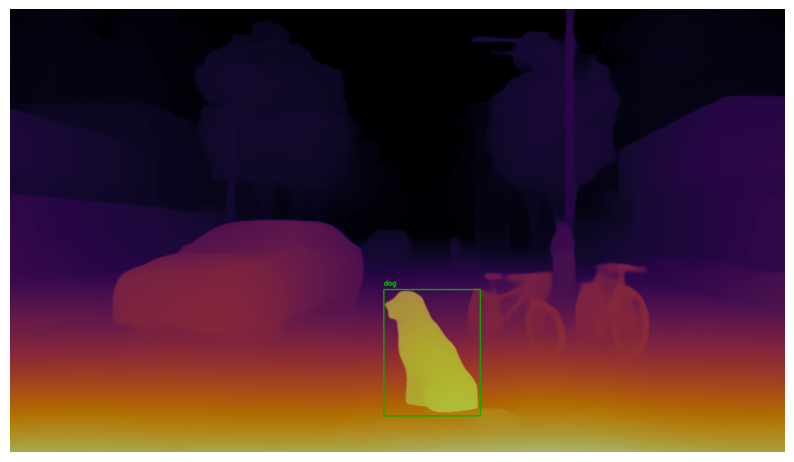

In [10]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

from da_od.config import class_names, output_img, sam_weights
from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

class_names_file = class_names / "coco.names.txt"
output_folder_path = output_img / "segmentation.jpg"
checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


def read_class_names(file_path):
    with open(file_path) as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names


classNames = read_class_names(class_names_file)

# Instantiate the model manager with the checkpoint path
sam_model_manager = SamModelManager(checkpoint_path)
model = sam_model_manager.load_model()

# Now, use ObjectDetector as before (assuming no changes needed here)
object_detector = ObjectDetector(model_name="yolo_nas_l", pretrained_weights="coco", conf_threshold=0.25)
bboxes, confidence, labels, class_names, image = object_detector.detect_objects(DepthAnything_colored)

# Using DisplayUtils for showing annotations
display_utils = VisualizationTools()

# Generate and display mask
mask_generator = SamAutomaticMaskGenerator(model)
mask = mask_generator.generate(image)
VisualizationTools.show_anns(mask)

# Further operations as before
# image = cv2.imread(str(image_path))
predictor = SamPredictor(model)
predictor.set_image(image)

combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

for i, label in enumerate(labels):
    input_box = np.array(bboxes[i])

    mask, _, _ = predictor.predict(
        point_coords=None, point_labels=None, box=input_box[None, :], multimask_output=False
    )

    cls = int(label)
    class_name = classNames[cls]

    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
    cv2.putText(
        image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
    )

    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)

plt.close("all")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis("off")
plt.savefig(output_folder_path)
plt.show()